In [1]:
import pandas as pd
import numpy as np
import joblib 

import plydata.cat_tools as cat 
import plotnine as pn

from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV

pn.options.dpi = 300



In [2]:
cdnow_raw_df = pd.read_csv(
    "data/CDNOW_master.txt",
    sep = "\s+",
    names = ["customer_id","date","transNumber","transAmount"]
)

In [3]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   transNumber  69659 non-null  int64  
 3   transAmount  69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [4]:
cdnow_raw_df

,customer_id,date,transNumber,transAmount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76
...,...,...,...,...
69654,23568,19970405,4,83.74
69655,23568,19970422,1,14.99
69656,23569,19970325,2,25.74
69657,23570,19970325,3,51.12


In [5]:
cdnow_df = cdnow_raw_df \
    .assign(
        date = lambda x: x['date'].astype(str)
    )\
    .assign(
        date = lambda x: pd.to_datetime(x['date'])        
    )\
    .dropna()


In [6]:
cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   transNumber  69659 non-null  int64         
 3   transAmount  69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [7]:
cdnow_df

,customer_id,date,transNumber,transAmount
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [8]:
cdnow_first_transactions_tbl = cdnow_df\
    .sort_values(['customer_id','date'])\
    .groupby('customer_id')\
    .first()

In [9]:
cdnow_first_transactions_tbl

,date,transNumber,transAmount
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [10]:
cdnow_first_transactions_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [11]:
cdnow_first_transactions_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

<Axes: xlabel='date'>

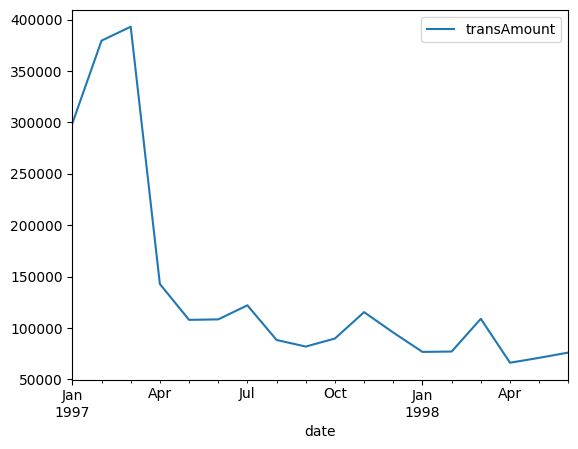

In [12]:
cdnow_df\
    .reset_index()\
    .set_index('date')\
    [['transAmount']]\
    .resample(
        rule = "MS"
    )\
    .sum()\
    .plot()


In [13]:
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

In [14]:
cdnow_cust_id_subset_df = cdnow_df\
    [cdnow_df['customer_id'].isin(ids_selected)]\
    .groupby(['customer_id','date'])\
    .sum()\
    .reset_index()


/home/moringa/Charles/env/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/moringa/Charles/env/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/moringa/Charles/env/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


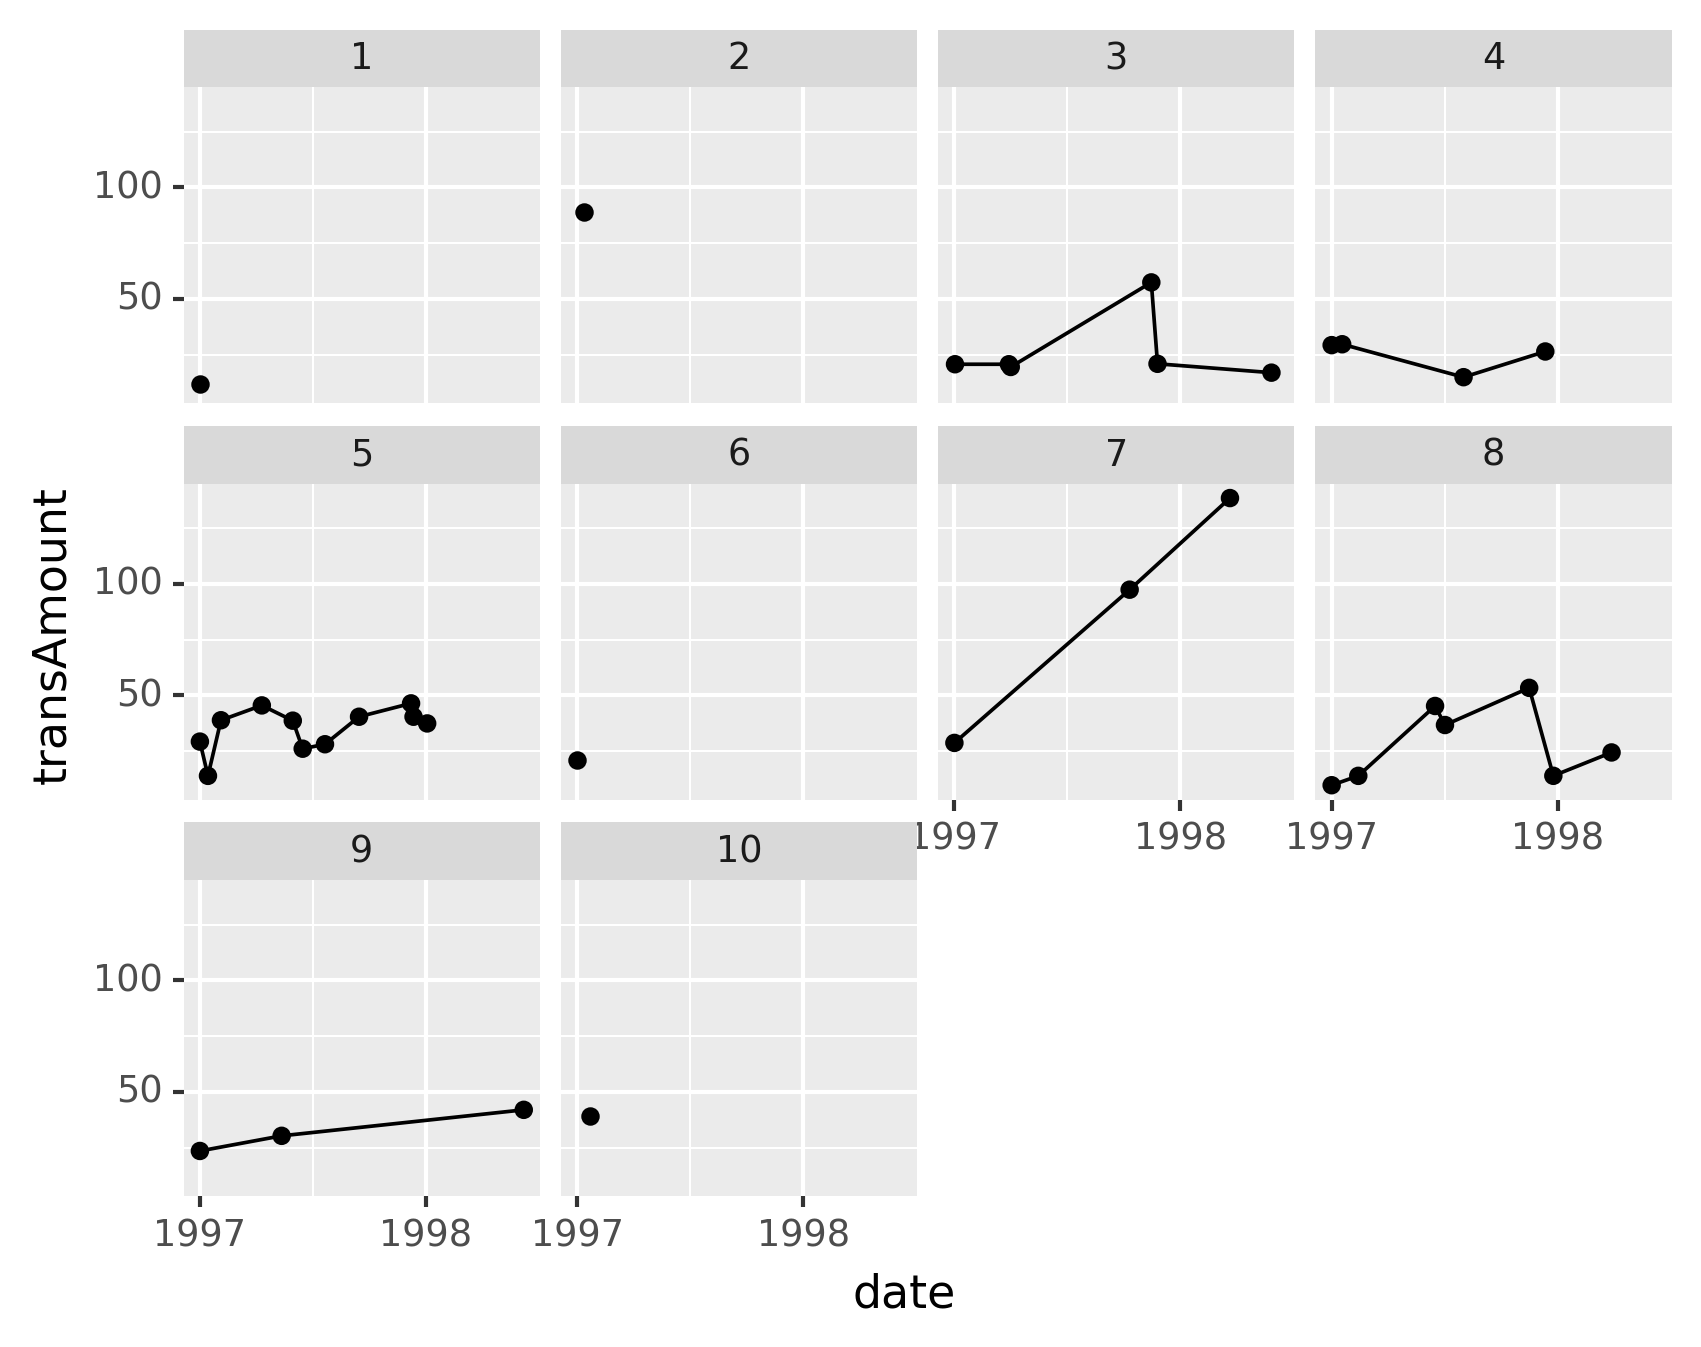

<ggplot: (8733739290811)>

In [15]:
pn.ggplot(
    data=cdnow_cust_id_subset_df,
    mapping=pn.aes(x='date', y='transAmount', group='customer_id')
) + \
pn.geom_line() + \
pn.geom_point() + \
pn.facet_wrap('customer_id') + \
pn.scale_x_date(
    date_breaks='1 Year',
    date_labels='%Y'
)

# With this code we can visualize how many times each selected customer made transactions with the bank 


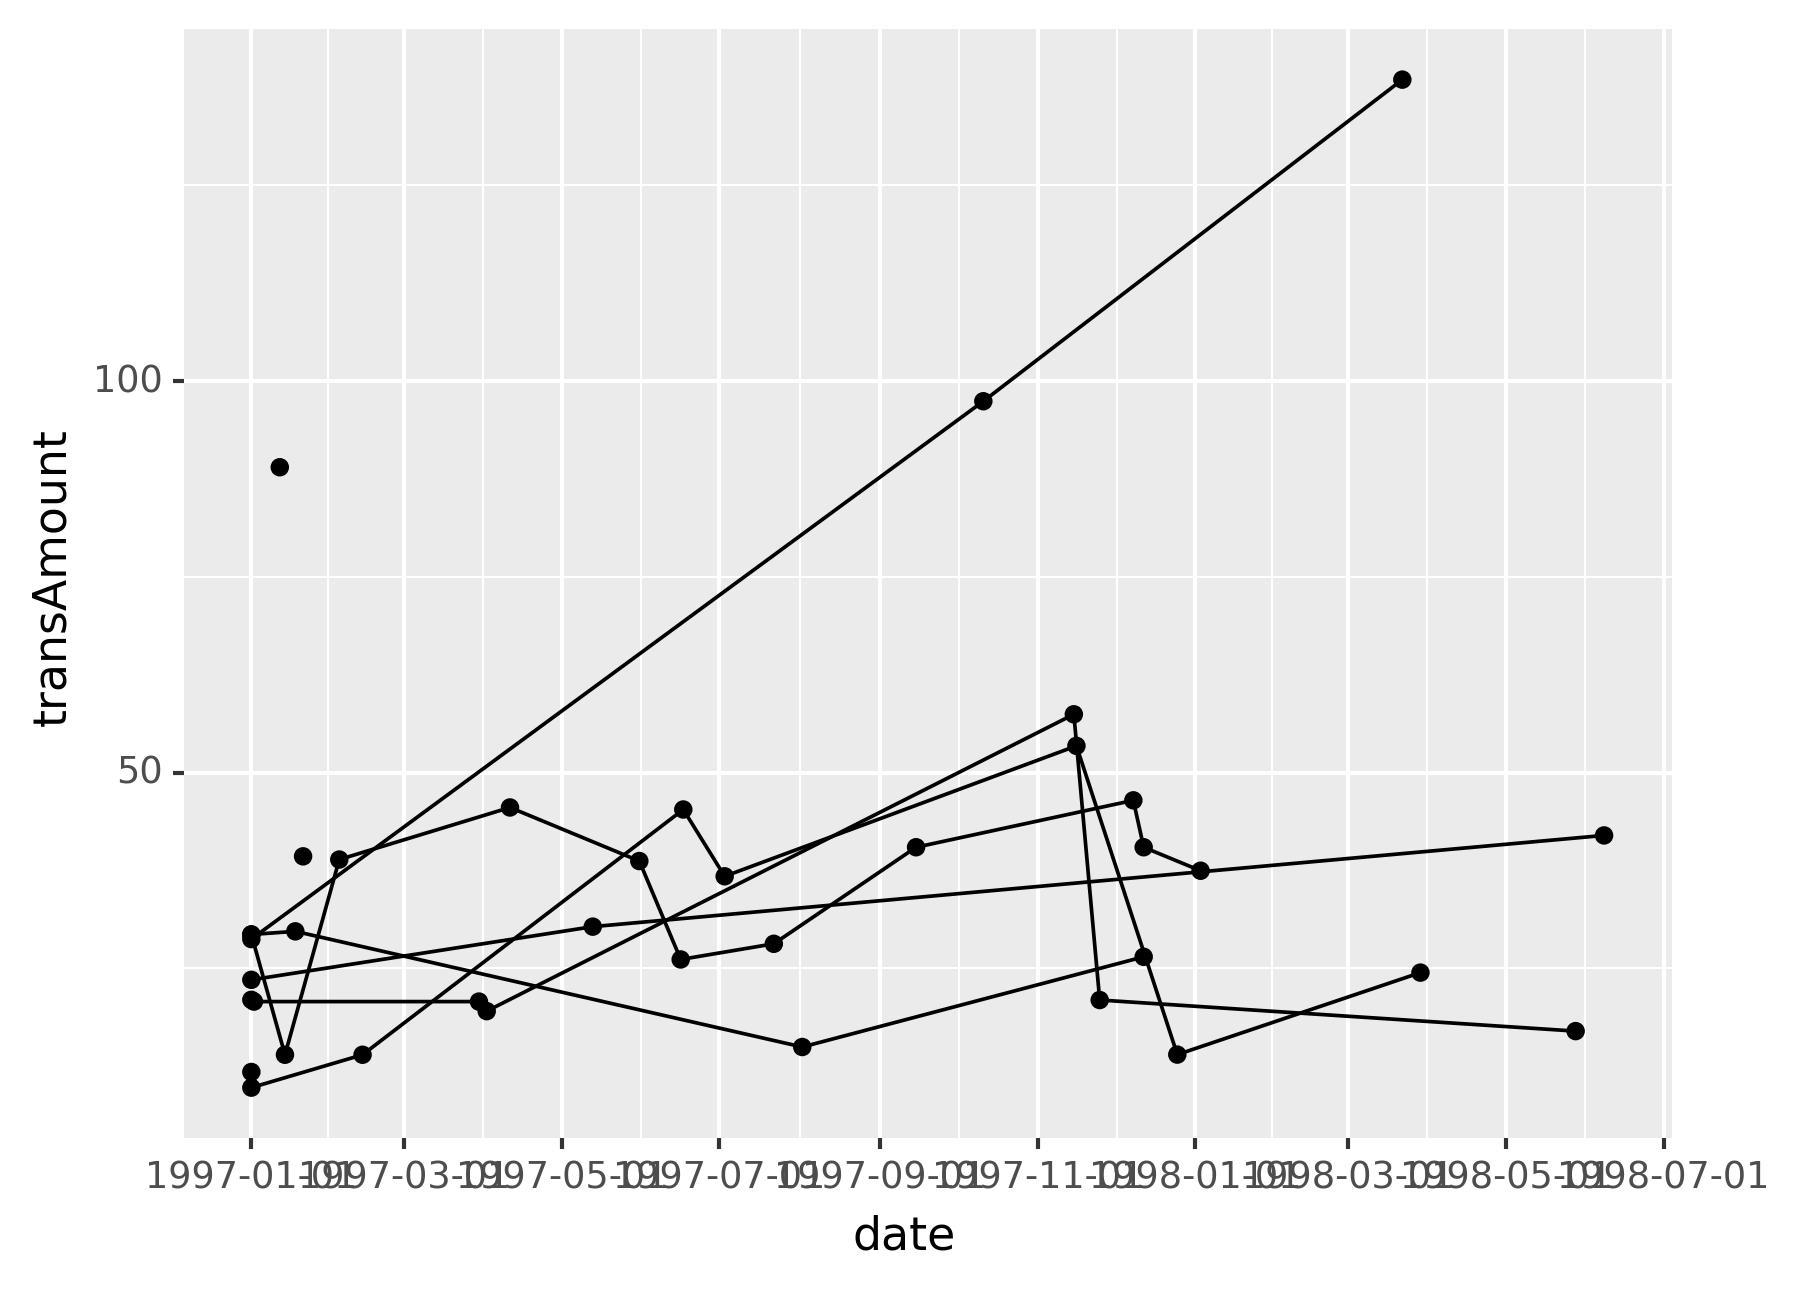

<ggplot: (8733739283300)>

In [16]:
    
    
pn.ggplot(
    data=cdnow_cust_id_subset_df,
    mapping=pn.aes(x='date', y='transAmount', group='customer_id')
) + \
pn.geom_line() + \
pn.geom_point()
# This code helps us visualize all the purchases made by the ten selected customers all in one place

In [17]:
n_days = 90
max_date = cdnow_df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")

temporal_in_df = cdnow_df \
    [cdnow_df['date']<=cutoff]
temporal_out_df = cdnow_df \
    [cdnow_df['date'] > cutoff]  

In [18]:
cdnow_df

,customer_id,date,transNumber,transAmount
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [19]:
max_date

Timestamp('1998-06-30 00:00:00')

In [20]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [21]:
temporal_in_df

,customer_id,date,transNumber,transAmount
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [22]:
temporal_out_df

,customer_id,date,transNumber,transAmount
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97
...,...,...,...,...
69583,23534,1998-05-02,1,10.48
69623,23555,1998-05-01,4,49.96
69624,23555,1998-06-10,2,27.48
69631,23556,1998-06-07,2,28.98


In [23]:
temporal_out_df\
    .drop('transNumber',axis=1)

,customer_id,date,transAmount
8,3,1998-05-28,16.99
38,9,1998-06-08,41.98
68,25,1998-04-17,12.99
69,25,1998-05-25,10.49
70,25,1998-06-03,24.97
...,...,...,...
69583,23534,1998-05-02,10.48
69623,23555,1998-05-01,49.96
69624,23555,1998-06-10,27.48
69631,23556,1998-06-07,28.98


In [24]:
targets_df = temporal_out_df\
    .drop('transNumber', axis=1)\
    .groupby('customer_id')\
    .agg({'transAmount': 'sum', 'date': 'max'})\
    .rename({'transAmount': 'trans_90_total'}, axis=1)\
    .assign(trans_90_flag=lambda x: (x['date'] >= cutoff).astype(int))\
    .drop('date', axis=1)


In [25]:
targets_df

,trans_90_total,trans_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [26]:
max_date = temporal_in_df['date'].max()


In [27]:
temporal_in_df

,customer_id,date,transNumber,transAmount
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [28]:
recency_features_df = temporal_in_df\
    [['customer_id', 'date']]\
    .groupby('customer_id')\
    .apply(
        lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, 'day')
    )\
    .to_frame()\
    .set_axis(['recency'], axis=1)


In [29]:
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [30]:
frequency_feature_df = temporal_in_df\
    [['customer_id','date']]\
    .groupby('customer_id')\
    .count()\
    .set_axis(['frequency'],axis=1)            


In [31]:
frequency_feature_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [32]:
transamount_feature_df = temporal_in_df\
    .groupby('customer_id')\
    .aggregate(
        {'transAmount': ['sum','mean']}
    )\
    .set_axis(['transAmount_sum','transAmount_mean'], axis=1)

In [33]:
transamount_feature_df

,transAmount_sum,transAmount_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [34]:
features_df = pd.concat(
    [recency_features_df,frequency_feature_df,transamount_feature_df],axis=1
)\
    .merge(
        targets_df,
        left_index = True,
        right_index = True,
        how = 'left'
        
    )\
    .fillna(0)


In [35]:
features_df

,recency,frequency,transAmount_sum,transAmount_mean,trans_90_total,trans_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [36]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import  GridSearchCV

X = features_df [['recency','frequency','transAmount_sum','transAmount_mean']]


In [37]:
y_spend = features_df['trans_90_total']

xgb_reg_spec = XGBRegressor(
    objective = "reg:squarederror",
    random_state = 123
)

In [38]:
y_spend = features_df['trans_90_total']

xgb_reg_spec = XGBRegressor(
    objective="reg:squarederror",
    random_state=123
)

xgb_reg_model = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=dict(
        learning_rate=[0.01, 0.1, 0.3, 0.5]
    ),
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

xgb_reg_model.fit(X, y_spend)
xgb_reg_model.best_score_
xgb_reg_model.best_params_
xgb_reg_model.best_estimator_
predictions_reg = xgb_reg_model.predict(X)


In [41]:
xgb_reg_model.best_score_


-9.799799543254297

In [40]:
predictions_reg

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

In [54]:
y_prob = features_df['trans_90_flag']

xgb_clf_spec = XGBClassifier(
    objective = 'binary:logistic',
    random_state = 123
)

xgb_clf_model = GridSearchCV(
    estimator = xgb_clf_spec,
    param_grid = dict(
        learning_rate = [0.01,0.1,0.3,0.5]
    ),
    scoring = 'roc_auc',
    refit = True,
    cv = 5   
    
)
    
xgb_clf_model.fit(X, y_prob)
xgb_clf_model.best_score_
xgb_clf_model.best_params_
xgb_clf_model.best_estimator_
predictions_clf = xgb_clf_model.predict_proba(X)

In [55]:
predictions_clf

array([[0.79955226, 0.20044775],
       [0.7899691 , 0.21003091],
       [0.6596401 , 0.34035996],
       ...,
       [0.76217   , 0.23782998],
       [0.7955098 , 0.20449017],
       [0.77555573, 0.22444429]], dtype=float32)

In [56]:
xgb_clf_model.best_score_


0.8356508197983127

In [57]:
xgb_clf_model.best_estimator_


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [58]:
imp_trans_amount_dict = xgb_reg_model\
    .best_estimator_\
    .get_booster()\
    .get_score(importance_type = 'gain')
    
imp_trans_amount_df = pd.DataFrame(
    data ={
        'feature': list (imp_trans_amount_dict.keys()),
        'value': list(imp_trans_amount_dict.values())
    }
)\
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] ,x['value'])
    )
    


In [61]:
imp_trans_amount_dict

{'recency': 2.3767943382263184,
 'frequency': 2.662660837173462,
 'transAmount_sum': 0.489593505859375,
 'transAmount_mean': 0.521847665309906}

In [62]:
imp_trans_amount_df

,feature,value
0,recency,2.376794
1,frequency,2.662661
2,transAmount_sum,0.489594
3,transAmount_mean,0.521848


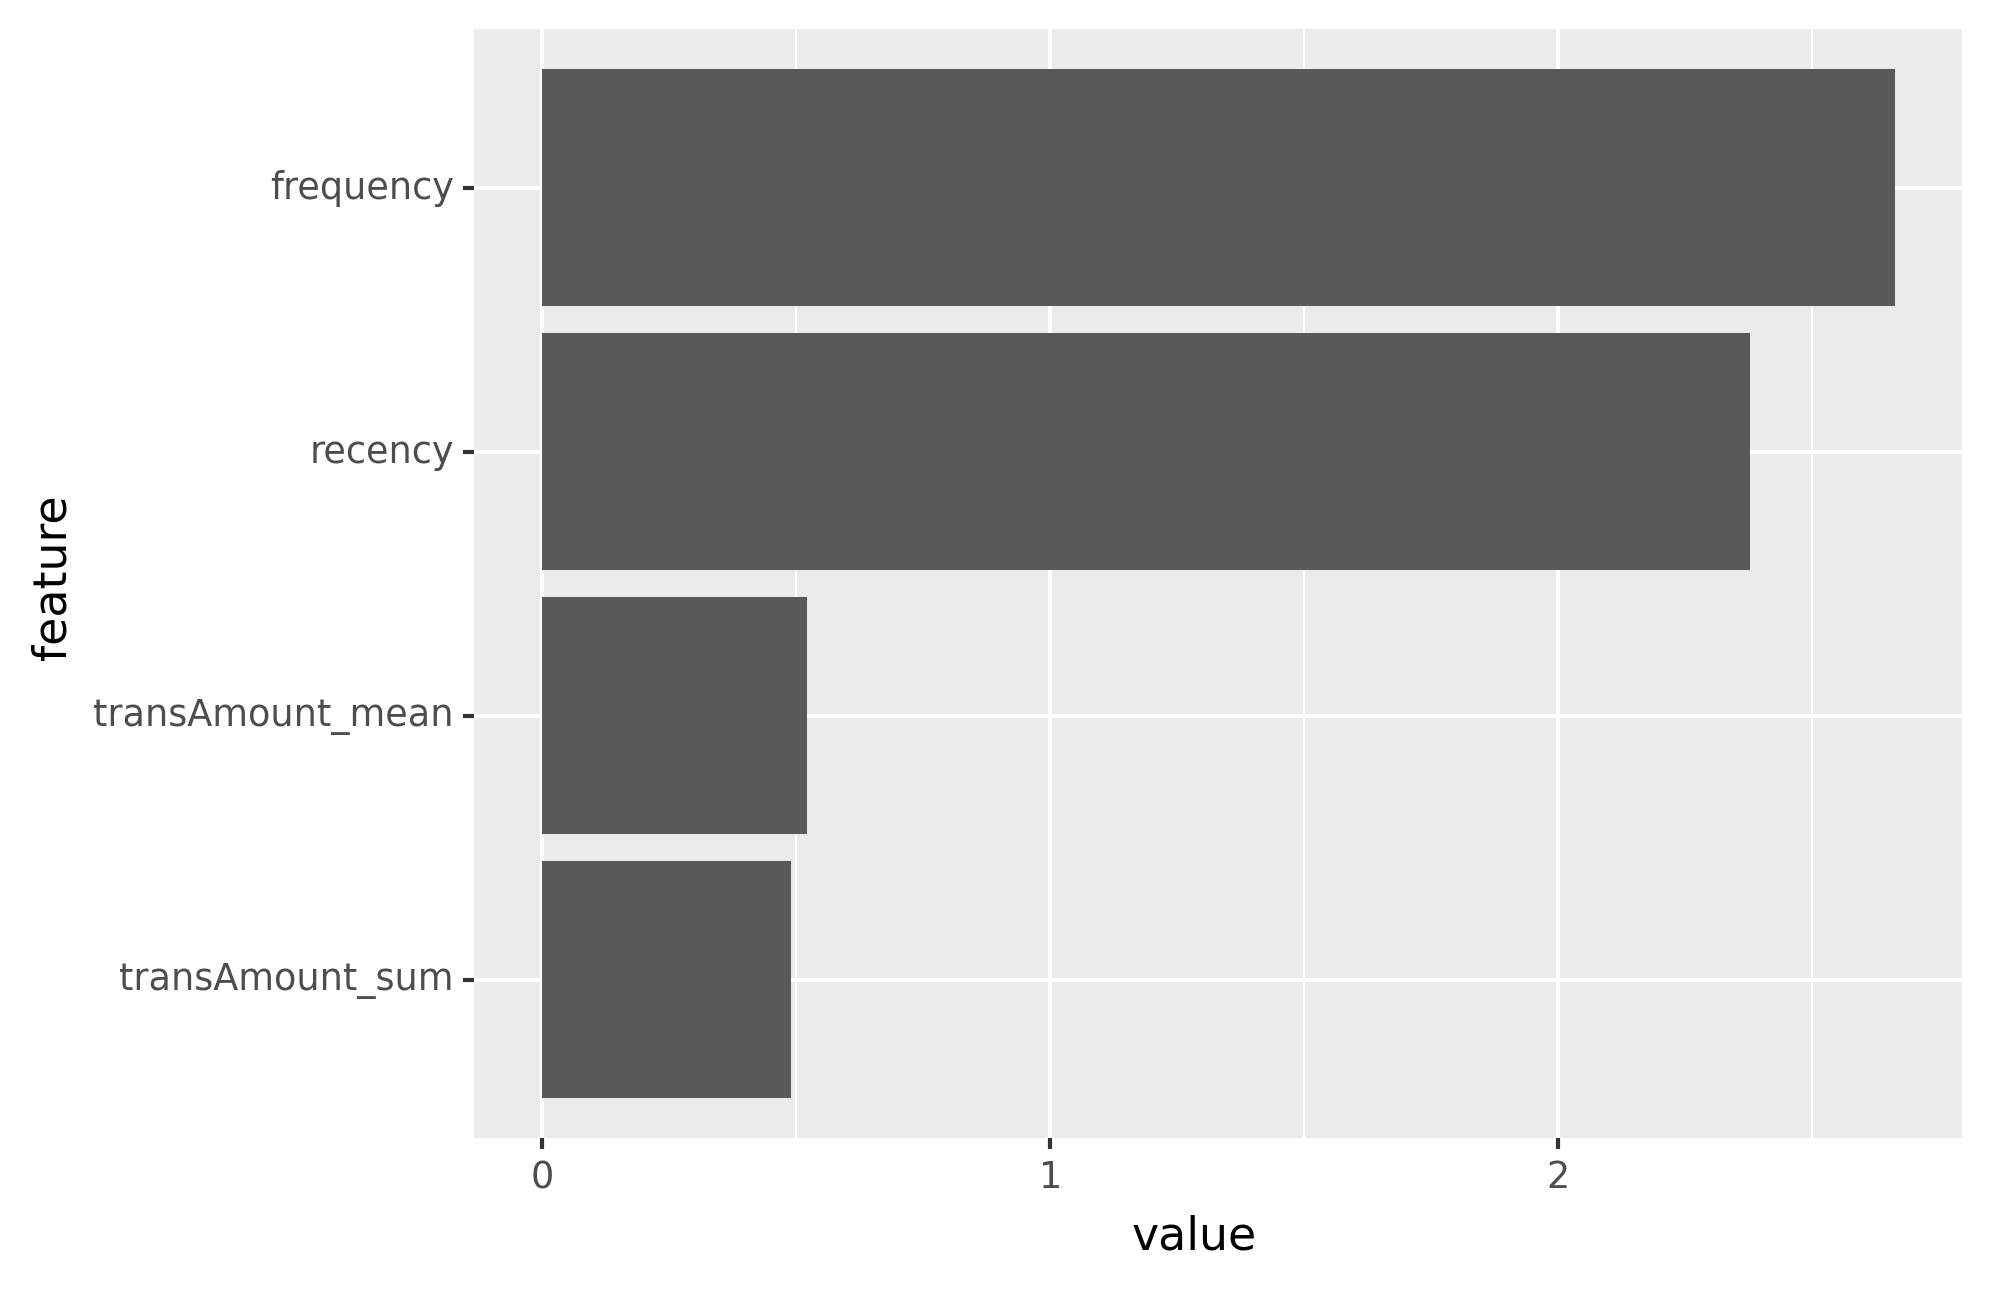

<ggplot: (8733736324060)>

In [64]:
pn.ggplot(
    pn.aes('feature', 'value'),
    imp_trans_amount_df
) + pn.geom_col() + pn.coord_flip()


In [65]:
xgb_clf_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [67]:
imp_trans_prob_dict = xgb_clf_model\
    .best_estimator_\
    .get_booster()\
    .get_score(importance_type='gain')

imp_trans_prob_df = pd.DataFrame(
    data={
        'feature': list(imp_trans_prob_dict.keys()),
        'value': list(imp_trans_prob_dict.values())
    }
).assign(
    feature=lambda x: cat.cat_reorder(x['feature'], x['value'])
)

    

In [71]:


plot = pn.ggplot(
    pn.aes('feature', 'value'),
    imp_trans_prob_df
) + pn.geom_col() + pn.coord_flip()



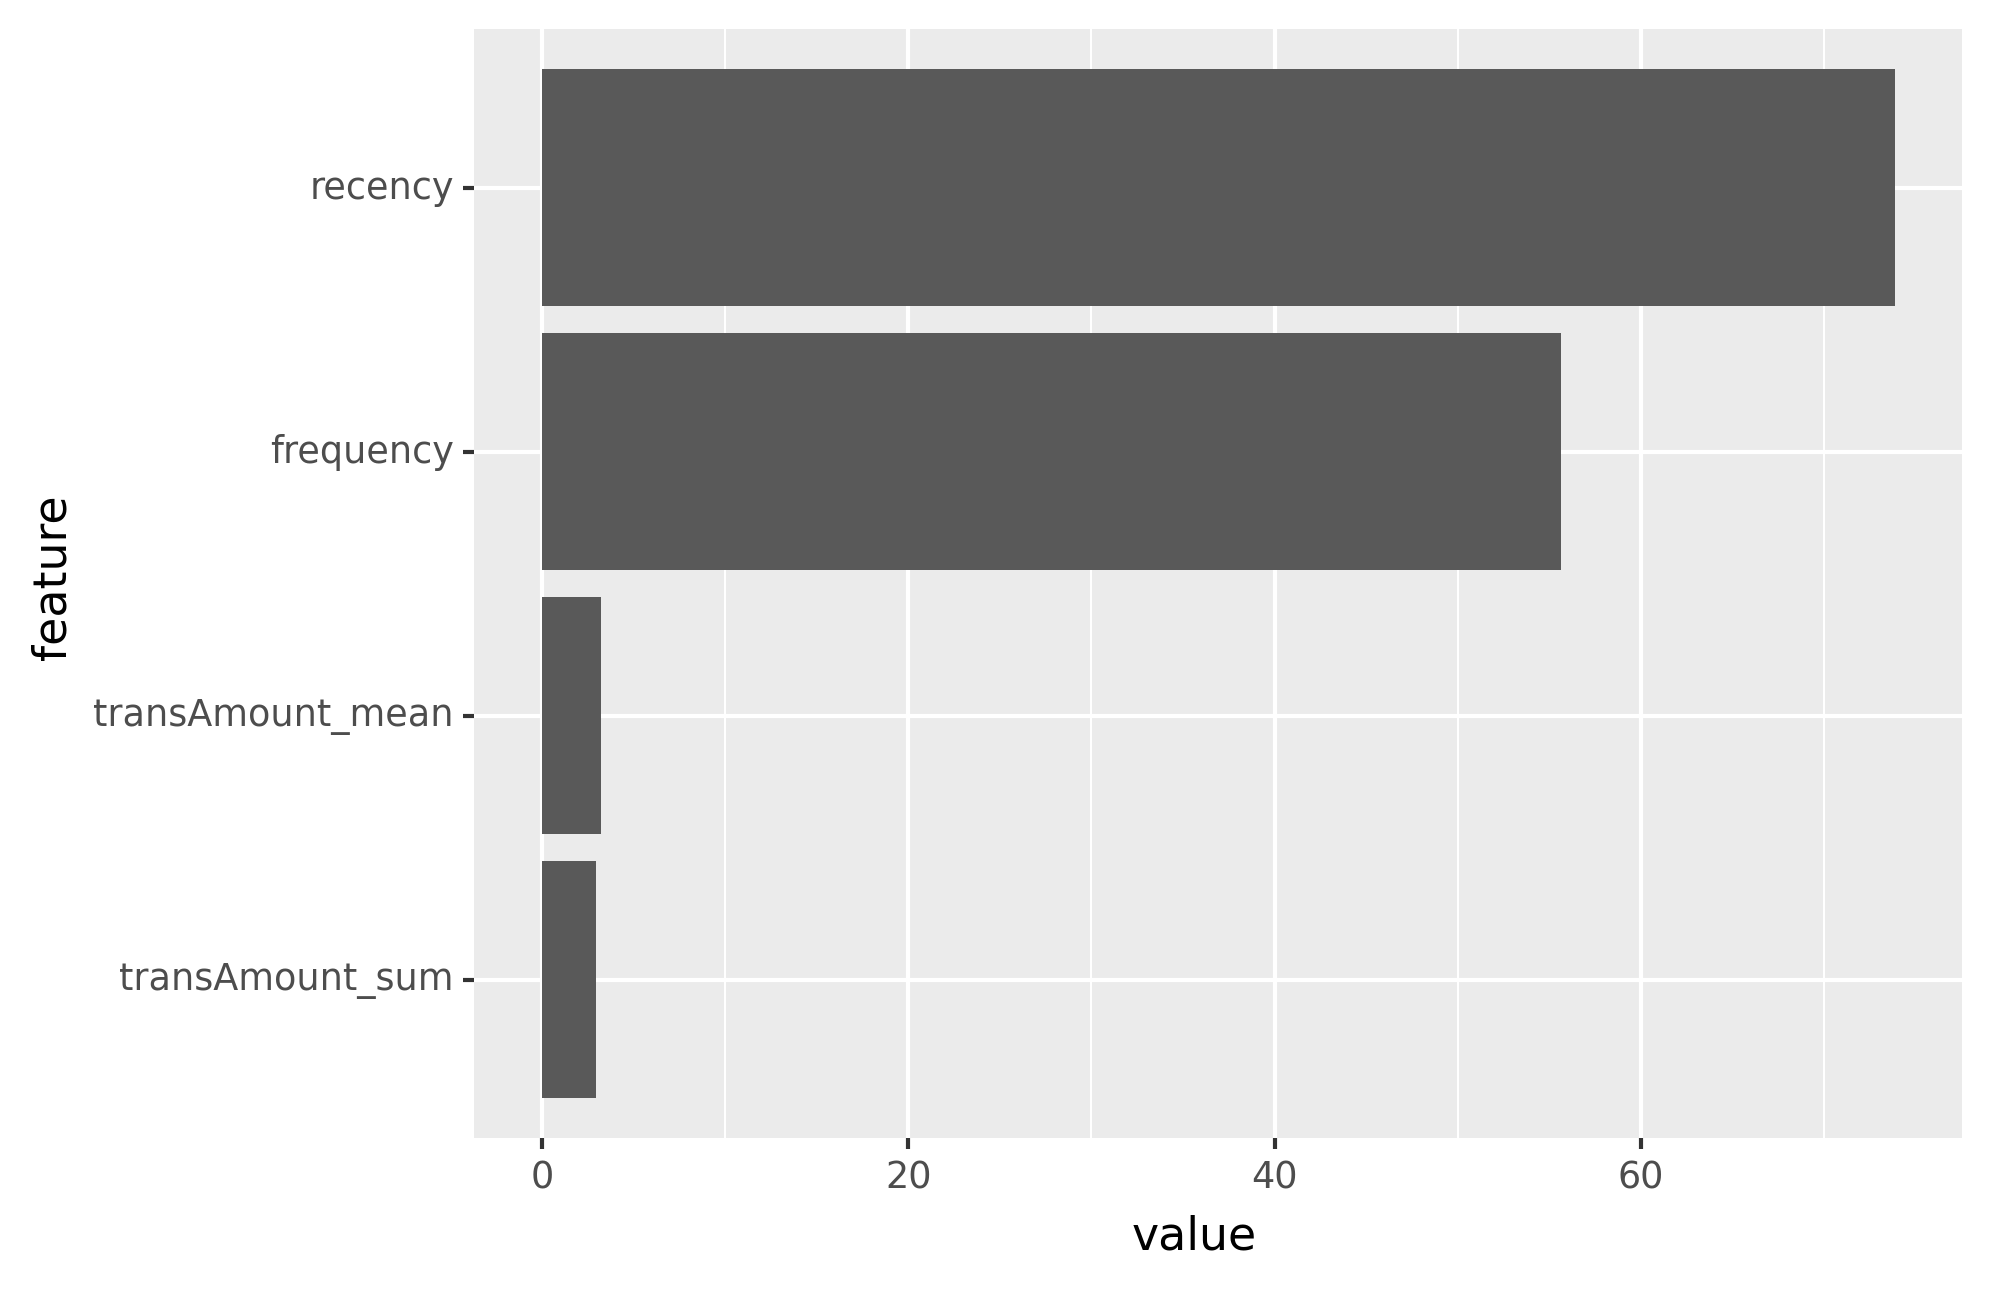

<ggplot: (8733736968954)>

In [73]:
plot

In [74]:
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_trans'],axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'],axis=1),
        features_df.reset_index()
    ],
    axis = 1
)

In [75]:
predictions_df

,pred_trans,pred_prob,customer_id,recency,frequency,transAmount_sum,transAmount_mean,trans_90_total,trans_90_flag
0,0.020080,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,0.035220,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,0.262934,0.340360,3,-127.0,5,139.47,27.894000,16.99,1.0
3,0.274930,0.340360,4,-110.0,4,100.50,25.125000,0.00,0.0
4,0.518241,0.553008,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.035606,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.038567,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,0.073170,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.046125,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [77]:
predictions_df.to_pickle('artifacts/predictions_df.pkl')
pd.read_pickle('artifacts/predictions_df.pkl')

,pred_trans,pred_prob,customer_id,recency,frequency,transAmount_sum,transAmount_mean,trans_90_total,trans_90_flag
0,0.020080,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,0.035220,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,0.262934,0.340360,3,-127.0,5,139.47,27.894000,16.99,1.0
3,0.274930,0.340360,4,-110.0,4,100.50,25.125000,0.00,0.0
4,0.518241,0.553008,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.035606,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.038567,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,0.073170,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.046125,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [78]:

imp_trans_amount_df.to_pickle("artifacts/imp_trans_amount_df.pkl")
imp_trans_prob_df.to_pickle("artifacts/imp_trans_prob_df.pkl")

pd.read_pickle("artifacts/imp_trans_amount_df.pkl")

,feature,value
0,recency,2.376794
1,frequency,2.662661
2,transAmount_sum,0.489594
3,transAmount_mean,0.521848


In [81]:
pd.read_pickle("artifacts/imp_trans_amount_df.pkl")

,feature,value
0,recency,2.376794
1,frequency,2.662661
2,transAmount_sum,0.489594
3,transAmount_mean,0.521848


In [88]:
joblib.dump(xgb_reg_model,'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')



['artifacts/xgb_clf_model.pkl']

In [89]:
model = joblib.load('artifacts/xgb_reg_model.pkl')


In [90]:
model.predict(X)

array([0.02008045, 0.03522014, 0.2629336 , ..., 0.07316955, 0.04612538,
       0.07994691], dtype=float32)

In [92]:
predictions_df.sort_values(by='pred_trans', ascending=False)


,pred_trans,pred_prob,customer_id,recency,frequency,transAmount_sum,transAmount_mean,trans_90_total,trans_90_flag
14047,1.055964,0.782431,14048,0.0,180,7267.15,40.373056,1709.18,1.0
709,1.045336,0.782431,710,-2.0,51,2216.45,43.459804,285.85,1.0
12859,1.039956,0.782431,12860,-3.0,30,1389.08,46.302667,457.26,1.0
8034,1.038419,0.782431,8035,-3.0,42,1332.67,31.730238,376.24,1.0
2483,1.032814,0.782431,2484,0.0,59,1438.93,24.388644,345.43,1.0
...,...,...,...,...,...,...,...,...,...
2072,-0.017285,0.210031,2073,-446.0,2,468.53,234.265000,0.00,0.0
17129,-0.018611,0.203830,17130,-395.0,1,192.13,192.130000,0.00,0.0
2561,-0.018636,0.218489,2562,-392.0,3,385.99,128.663333,0.00,0.0
8283,-0.023072,0.210031,8284,-424.0,2,339.73,169.865000,0.00,0.0


In [1]:
predictions_df.loc[(predictions_df['recency'] > -90) & (predictions_df['pred_prob'] < 0.20)].sort_values(by='pred_prob', ascending=False)


NameError: name 'predictions_df' is not defined

In [97]:
predictions_df\
    [predictions_df['trans_90_total']==0.0]\
    .sort_values('pred_trans',ascending= False)

,pred_trans,pred_prob,customer_id,recency,frequency,transAmount_sum,transAmount_mean,trans_90_total,trans_90_flag
10532,0.818311,0.685106,10533,-6.0,11,388.50,35.318182,0.0,0.0
10612,0.799071,0.740082,10613,-3.0,13,523.72,40.286154,0.0,0.0
18026,0.791035,0.692150,18027,-9.0,10,267.47,26.747000,0.0,0.0
8586,0.768495,0.688253,8587,-14.0,16,860.04,53.752500,0.0,0.0
19946,0.766348,0.718698,19947,-8.0,19,539.11,28.374211,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2072,-0.017285,0.210031,2073,-446.0,2,468.53,234.265000,0.0,0.0
17129,-0.018611,0.203830,17130,-395.0,1,192.13,192.130000,0.0,0.0
2561,-0.018636,0.218489,2562,-392.0,3,385.99,128.663333,0.0,0.0
8283,-0.023072,0.210031,8284,-424.0,2,339.73,169.865000,0.0,0.0
